In [7]:
import sys
print(sys.version)

3.5.2 |Anaconda 2.4.1 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib import gridspec
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from scipy.stats import ttest_ind as ttest
from collections import Counter

In [9]:
import matplotlib
print(matplotlib.__version__)
# Big mac: 2.2.2 (old 1.5)
# Work mac: 2.1.0

2.2.2


In [10]:
file_name = "ExperimentData.csv"

# Clean up file:
# Read in the file
with open(file_name, 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace('NA,NA,NA,NA', 'NA,NA,NA') 

# Write the file out again
with open(file_name, 'w') as file:
    file.write(filedata)

# Make data ready:
df = pd.read_csv(file_name)
df[38:43]

,id,gender,age,time,type,type_order,stim_order,stim,response,pitch,roll,yaw,reaction_time
38,0,Male,24,Sun May 20 18:44:35 GMT+02:00 2018,slider_num,1,18,50,51.17,NaN,NaN,NaN,5742
39,0,Male,24,Sun May 20 18:44:44 GMT+02:00 2018,slider_num,1,19,65,61.88,NaN,NaN,NaN,8075
40,0,Male,24,Sun May 20 18:45:07 GMT+02:00 2018,arm_num,2,0,63,46.30,41.633152,20.192804,304.02070,17045
41,0,Male,24,Sun May 20 18:45:14 GMT+02:00 2018,arm_num,2,1,12,23.30,20.955986,21.641567,290.03125,4639
42,0,Male,24,Sun May 20 18:45:22 GMT+02:00 2018,arm_num,2,2,79,48.70,43.794170,18.117966,299.70346,6171


<h1>Gender & age</h1>

Gender
Males: 18
Females: 6
Total: 24
- - - - - - - - - - - - - - - - - - - - 
Age
Mean: 27.83
Median: 26.5


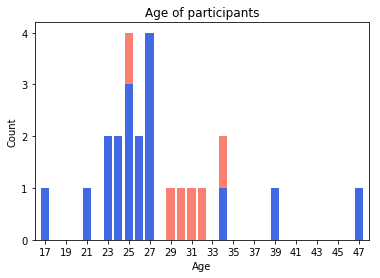

In [11]:
# Gender
males = df.loc[df['gender']=='Male'].id.unique()
females = df.loc[df['gender']=='Female'].id.unique()
print("Gender")
print("Males:",len(males))
print("Females:",len(females))
print("Total:",len(males)+len(females))
print("- "*20)

# Age
allages = df.drop_duplicates('id')[['id','gender','age']]
mages = list(allages.loc[allages['gender']=='Male']['age'])
fages = list(allages.loc[allages['gender']=='Female']['age'])
print('Age')
print('Mean:',round(np.mean(allages['age']),2))
print('Median:',np.median(allages['age']))




uages = sorted(list(set(allages['age'])))
my = []
fy = []
for a in uages:
    my.append(mages.count(a))
    fy.append(fages.count(a))

fig = plt.figure(figsize=(6,4), facecolor='white')
plt.bar(uages,my,color='royalblue')
plt.bar(uages,fy,bottom=my,color='salmon')
plt.yticks((np.arange(0, 5, step=1)))
plt.xticks((np.arange(15, 50, step=2)))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title("Age of participants")
plt.xlim([16,48])
plt.ylim([0,4.2])

plt.show()

<h1>Remove outliers</h1>

In [12]:
num_types = ["slider_num", "wrist_num", "arm_num"]
grey_types = ["slider_grey", "wrist_grey", "arm_grey"]
dft = df.loc[(abs(df['stim']-df['response']) > 25) & df['type'].isin(grey_types)] # Find outliers in grey exercises
dft = dft.append(df.loc[(abs(df['stim']-df['response']) > 50) & df['type'].isin(num_types)]) # -||- in num exercises
dft

,id,gender,age,time,type,type_order,stim_order,stim,response,pitch,roll,yaw,reaction_time
77,0,Male,24,Sun May 20 18:49:02 GMT+02:00 2018,wrist_grey,3,17,3,28.1750,-1.684786,51.767326,285.30933,3785
478,3,Male,34,Wed May 23 15:07:19 GMT+02:00 2018,slider_grey,5,28,10,38.9109,NaN,NaN,NaN,2004
1080,9,Male,25,Fri May 25 11:09:31 GMT+02:00 2018,wrist_num,0,79,6,79.0000,-17.046492,71.109856,74.16516,12244
1620,13,Female,34,Mon May 28 09:36:11 GMT+02:00 2018,wrist_num,3,58,77,18.2000,143.890780,16.414879,238.16380,4039


In [13]:
print("Total datapoints:",len(df["id"]))

Total datapoints: 2880


In [14]:
df = df.loc[~df['time'].isin(dft['time'])] # Remove outliers
print("Datapoints after remoal:",len(df["id"]))

Datapoints after remoal: 2876


<H1>Standard deviation & variance of the absolute error for each subject</H1>

In [15]:
columns = df.columns.values
types = ["slider_grey", "slider_num", "wrist_grey", "wrist_num", "arm_grey", "arm_num"]
type_frames = []
for t in types:
    type_frames.append(df.loc[df['type'] == t])

In [16]:
participants_frames = []
participants_std = pd.DataFrame()
participants_var = pd.DataFrame()

for i in range(max(df.loc[: , "id"])+1):
    participants_frames.append(df.loc[df['id'] == i])
    
for pf in participants_frames:
    p_id = pf['id'].iloc[0]
    p_std = []
    p_var = []
    for t in types:
        tmp_df = pf.loc[pf['type'] == t]
        x = tmp_df.loc[: , columns[7]]
        y = round(tmp_df.loc[: , columns[8]])
        abs_errors = x.subtract(y).abs()
        error_std = np.std(abs_errors)
        error_var = np.var(abs_errors)
        p_std.append(error_std)
        p_var.append(error_var)
        
    mean_std = np.mean(p_std)
    median_std = np.median(p_std)
    mean_var = np.mean(p_var)
    median_var = np.median(p_var)
    
    tmp_df_std = pd.DataFrame([[p_id]+p_std+[mean_std,median_std]], columns=["id"]+types+["mean STD",'median STD'])
    participants_std = participants_std.append(tmp_df_std)
    tmp_df_var = pd.DataFrame([[p_id]+p_var+[mean_var,median_var]], columns=["id"]+types+["mean VAR",'median VAR'])
    participants_var = participants_var.append(tmp_df_var)
    
#    break

In [17]:
print("STANDARD DEVIATION")
print("MEAN")
print("Mean of mean STD:",np.mean(participants_std.loc[: , 'mean STD']))
print("Median of mean STD:",np.median(participants_std.loc[: , 'mean STD']))
print('MEDIAN')
print("Mean of median STD:",np.mean(participants_std.loc[: , 'median STD']))
print("Median of median STD:",np.median(participants_std.loc[: , 'median STD']))
participants_std

STANDARD DEVIATION
MEAN
Mean of mean STD: 4.745789141110047
Median of mean STD: 4.644813982673411
MEDIAN
Mean of median STD: 4.29579866853352
Median of median STD: 4.160456202266914


,id,slider_grey,slider_num,wrist_grey,wrist_num,arm_grey,arm_num,mean STD,median STD
0,0,4.510820,6.803492,6.123837,8.657222,3.389321,7.690904,6.195933,6.463665
0,1,2.900000,1.657558,3.309078,6.881134,2.353720,4.563716,3.610868,3.104539
0,2,3.150794,4.848711,3.040970,7.247586,4.352873,5.402546,4.673913,4.600792
0,3,6.099816,1.545154,6.680382,4.092676,3.134884,2.957617,4.085088,3.613780
0,4,4.364344,2.776689,4.739198,8.709047,5.290321,6.518435,5.399672,5.014760
0,5,2.709243,2.255549,4.497499,4.756837,3.380459,6.726626,4.054369,3.938979
0,6,2.554897,2.277608,5.488852,6.264184,4.873141,4.877243,4.389321,4.875192
0,7,3.980892,2.224298,4.501111,7.671212,3.948417,7.268253,4.932364,4.241001
0,8,4.222262,3.335791,5.517246,12.393950,4.188974,9.238371,6.482766,4.869754
0,9,2.108910,2.085066,3.583295,7.792674,4.080441,3.542245,3.865438,3.562770


In [18]:
print("VARIANCE")
print("MEAN")
print("Mean of mean VAR:",np.mean(participants_var.loc[: , 'mean VAR']))
print("Median of mean VAR:",np.median(participants_var.loc[: , 'mean VAR']))
print('MEDIAN')
print("Mean of median VAR:",np.mean(participants_var.loc[: , 'median VAR']))
print("Median of median VAR:",np.median(participants_var.loc[: , 'median VAR']))
participants_var

VARIANCE
MEAN
Mean of mean VAR: 27.536910058864265
Median of mean VAR: 25.274178785780236
MEDIAN
Mean of median VAR: 19.193258021698988
Median of median VAR: 17.581875


,id,slider_grey,slider_num,wrist_grey,wrist_num,arm_grey,arm_num,mean VAR,median VAR
0,0,20.347500,46.2875,37.501385,74.947500,11.4875,59.1500,41.620231,41.894443
0,1,8.410000,2.7475,10.950000,47.350000,5.5400,20.8275,15.970833,9.680000
0,2,9.927500,23.5100,9.247500,52.527500,18.9475,29.1875,23.891250,21.228750
0,3,37.207756,2.3875,44.627500,16.750000,9.8275,8.7475,19.924626,13.288750
0,4,19.047500,7.7100,22.460000,75.847500,27.9875,42.4900,32.590417,25.223750
0,5,7.340000,5.0875,20.227500,22.627500,11.4275,45.2475,18.659583,15.827500
0,6,6.527500,5.1875,30.127500,39.240000,23.7475,23.7875,21.436250,23.767500
0,7,15.847500,4.9475,20.260000,58.847500,15.5900,52.8275,28.053333,18.053750
0,8,17.827500,11.1275,30.440000,153.610000,17.5475,85.3475,52.650000,24.133750
0,9,4.447500,4.3475,12.840000,60.725762,16.6500,12.5475,18.593044,12.693750


In [19]:
compare_ex = pd.DataFrame()
mean_var = []
median_var = []
mean_std = []
median_std = []
for i in range(6):
    var = participants_var.loc[: , types[i]]
    std = participants_std.loc[: , types[i]]
    mean_var.append(np.mean(var))
    median_var.append(np.median(var))
    mean_std.append(np.mean(std))
    median_std.append(np.median(std))


titles = ["mean VAR","median VAR","mean STD","median STD"]
data = [mean_var,median_var,mean_std,median_std]
for i in range(4):
    tmp_df = pd.DataFrame([[titles[i]]+data[i]], columns=["calculation"]+types)
    compare_ex = compare_ex.append(tmp_df)
    
#    break
compare_ex

,calculation,slider_grey,slider_num,wrist_grey,wrist_num,arm_grey,arm_num
0,mean VAR,13.715115,8.389271,21.972974,64.347329,15.027708,41.769062
0,median VAR,12.147500,5.123750,20.800000,59.786631,14.087500,36.568750
0,mean STD,3.588844,2.653040,4.552522,7.665094,3.778681,6.236553
0,median STD,3.485208,2.263556,4.560317,7.731943,3.751150,6.047199


<h1>Investigating variance for each participant</h1>

In [20]:
participants_var[0:5]

,id,slider_grey,slider_num,wrist_grey,wrist_num,arm_grey,arm_num,mean VAR,median VAR
0,0,20.347500,46.2875,37.501385,74.9475,11.4875,59.1500,41.620231,41.894443
0,1,8.410000,2.7475,10.950000,47.3500,5.5400,20.8275,15.970833,9.680000
0,2,9.927500,23.5100,9.247500,52.5275,18.9475,29.1875,23.891250,21.228750
0,3,37.207756,2.3875,44.627500,16.7500,9.8275,8.7475,19.924626,13.288750
0,4,19.047500,7.7100,22.460000,75.8475,27.9875,42.4900,32.590417,25.223750


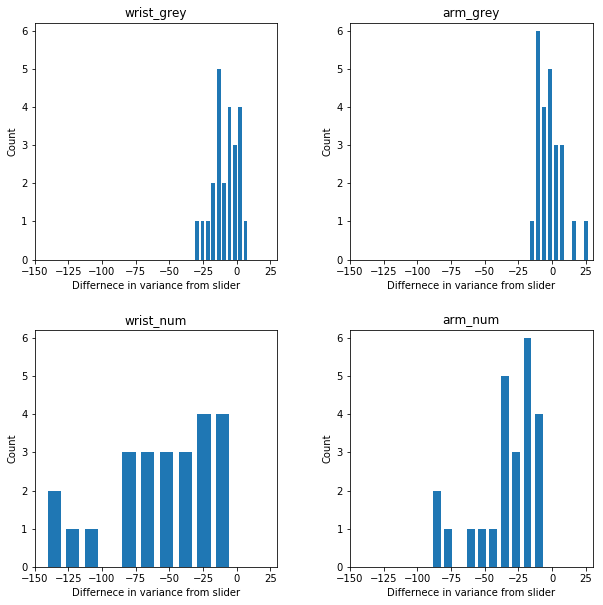

In [21]:
var_dif_wrist_grey = participants_var['slider_grey']-participants_var['wrist_grey']
var_dif_arm_grey = participants_var['slider_grey']-participants_var['arm_grey']
var_dif_wrist_num = participants_var['slider_num']-participants_var['wrist_num']
var_dif_arm_num = participants_var['slider_num']-participants_var['arm_num']

# Create figure with grid
fig = plt.figure(figsize=(10,10), facecolor='white')
gs = gridspec.GridSpec(2,2)
y_limit = 6.2
x_limit = [-150,30]

# Add 1st plot   
ax1 = fig.add_subplot(gs[0,0])
hist1, bins1 = np.histogram(var_dif_wrist_grey, bins=10)
width1 = 0.7 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2
ax1.bar(center1, hist1, align='center', width=width1)
ax1.set_title("wrist_grey")
ax1.set_xlabel("Differnece in variance from slider")
ax1.set_ylabel("Count")
ax1.set_ylim([0,y_limit])
ax1.set_xlim(x_limit)

# Add 2nd plot   
ax1 = fig.add_subplot(gs[0,1])
hist1, bins1 = np.histogram(var_dif_arm_grey, bins=10)
width1 = 0.7 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2
ax1.bar(center1, hist1, align='center', width=width1)
ax1.set_title("arm_grey")
ax1.set_xlabel("Differnece in variance from slider")
ax1.set_ylabel("Count")
ax1.set_ylim([0,y_limit])
ax1.set_xlim(x_limit)

# Add 3rd plot   
ax1 = fig.add_subplot(gs[1,0])
hist1, bins1 = np.histogram(var_dif_wrist_num, bins=10)
width1 = 0.7 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2
ax1.bar(center1, hist1, align='center', width=width1)
ax1.set_title("wrist_num")
ax1.set_xlabel("Differnece in variance from slider")
ax1.set_ylabel("Count")
ax1.set_ylim([0,y_limit])
ax1.set_xlim(x_limit)

# Add 4th plot   
ax1 = fig.add_subplot(gs[1,1])
hist1, bins1 = np.histogram(var_dif_arm_num, bins=10)
width1 = 0.7 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2
ax1.bar(center1, hist1, align='center', width=width1)
ax1.set_title("arm_num")
ax1.set_xlabel("Differnece in variance from slider")
ax1.set_ylabel("Count")
ax1.set_ylim([0,y_limit])
ax1.set_xlim(x_limit)

gs.update(wspace=0.3, hspace=0.3)

plt.show()

<h1>Histogram of errors</h1>

In [22]:
bins1

array([-89.83   , -81.41475, -72.9995 , -64.58425, -56.169  , -47.75375,
       -39.3385 , -30.92325, -22.508  , -14.09275,  -5.6775 ])

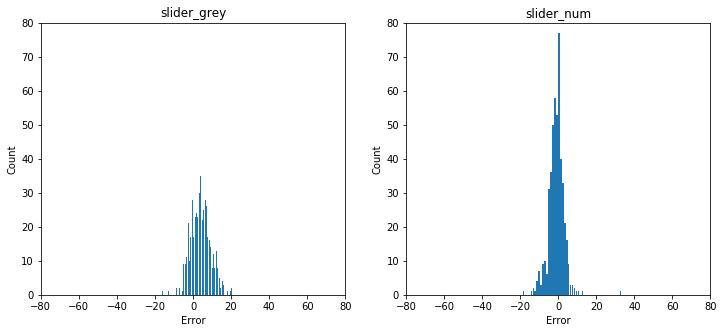

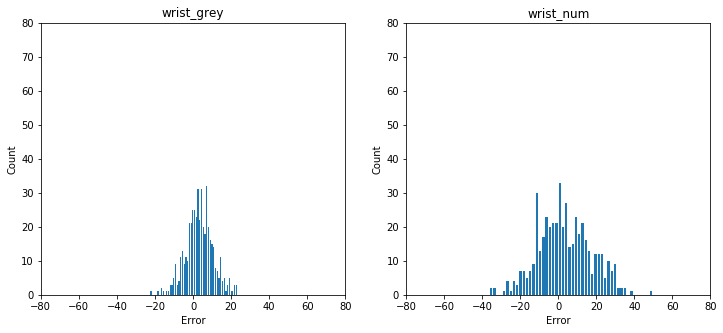

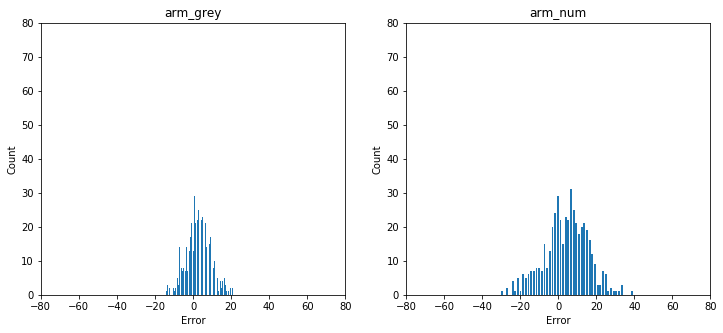

In [23]:
i = 0
plot_placement = [121, 122]
fs = (12,5)
fig = plt.figure(figsize=fs)
for t in types:
    if 'grey' in t:
        y_lim = 50
    else:
        y_lim = 100
    q = df.query('type==\''+t+'\'')
    x = q['response']-q['stim']

    ax1 = fig.add_subplot(plot_placement[i%2])
    hist1, bins1 = np.histogram(x, bins=50)#, normed=1)
    width1 = 0.7 * (bins1[1] - bins1[0])
    center1 = (bins1[:-1] + bins1[1:]) / 2
    ax1.bar(center1, hist1, align='center', width=width1)
    ax1.set_title(t)
    ax1.set_xlim([-80,80])
    ax1.set_ylim([0,80])
    ax1.set_xlabel("Error")
    ax1.set_ylabel("Count")
    #plt.show()
    if i%2 == 1:
        plt.show()
        if i != 5:
            fig = plt.figure(figsize=fs)
    i += 1
    #break

<h1>TTEST</h1>

In [24]:
#['slider_grey', 'slider_num', 'wrist_grey', 'wrist_num', 'arm_grey', 'arm_num']
print('- - - slider_grey vs wrist_grey - - -')
q1 = df.query('type==\'slider_grey\'')
e1 = q1['response']-q1['stim']
q2 = df.query('type==\'wrist_grey\'')
e2 = q2['response']-q2['stim'] 
tr = ttest(e1,e2)
print("p value:",tr.pvalue)
print("calculated t-statistic:",tr.statistic)
print()

print('- - - slider_grey vs arm_grey - - -')
q1 = df.query('type==\'slider_grey\'')
e1 = q1['response']-q1['stim']
q2 = df.query('type==\'arm_grey\'')
e2 = q2['response']-q2['stim'] 
tr = ttest(e1,e2)
print("p value:",tr.pvalue)
print("calculated t-statistic:",tr.statistic)
print()

print('- - - wrist_grey vs arm_grey - - -')
q1 = df.query('type==\'wrist_grey\'')
e1 = q1['response']-q1['stim']
q2 = df.query('type==\'arm_grey\'')
e2 = q2['response']-q2['stim'] 
tr = ttest(e1,e2)
print("p value:",tr.pvalue)
print("calculated t-statistic:",tr.statistic)
print()

print('- - - slider_num vs wrist_num - - -')
q1 = df.query('type==\'slider_num\'')
e1 = q1['response']-q1['stim']
q2 = df.query('type==\'wrist_num\'')
e2 = q2['response']-q2['stim'] 
tr = ttest(e1,e2)
print("p value:",tr.pvalue)
print("calculated t-statistic:",tr.statistic)
print()

print('- - - slider_num vs arm_num - - -')
q1 = df.query('type==\'slider_num\'')
e1 = q1['response']-q1['stim']
q2 = df.query('type==\'arm_num\'')
e2 = q2['response']-q2['stim'] 
tr = ttest(e1,e2)
print("p value:",tr.pvalue)
print("calculated t-statistic:",tr.statistic)
print()

print('- - - wrist_num vs arm_num - - -')
q1 = df.query('type==\'wrist_num\'')
e1 = q1['response']-q1['stim']
q2 = df.query('type==\'arm_num\'')
e2 = q2['response']-q2['stim'] 
tr = ttest(e1,e2)
print("p value:",tr.pvalue)
print("calculated t-statistic:",tr.statistic)
print()

- - - slider_grey vs wrist_grey - - -
p value: 0.10045038855035789
calculated t-statistic: 1.6442643179984084

- - - slider_grey vs arm_grey - - -
p value: 0.015975075474875935
calculated t-statistic: 2.413775441893687

- - - wrist_grey vs arm_grey - - -
p value: 0.610340008296786
calculated t-statistic: 0.5097559110326026

- - - slider_num vs wrist_num - - -
p value: 1.294678087837256e-10
calculated t-statistic: -6.4996043713777185

- - - slider_num vs arm_num - - -
p value: 9.350243091155525e-19
calculated t-statistic: -9.028592819984329

- - - wrist_num vs arm_num - - -
p value: 0.3934850515873848
calculated t-statistic: -0.8537000635827134



<H1>Historgram showing the distributions of stimuli and responses for each exersise together with a scatterplot</H1>

slider_grey


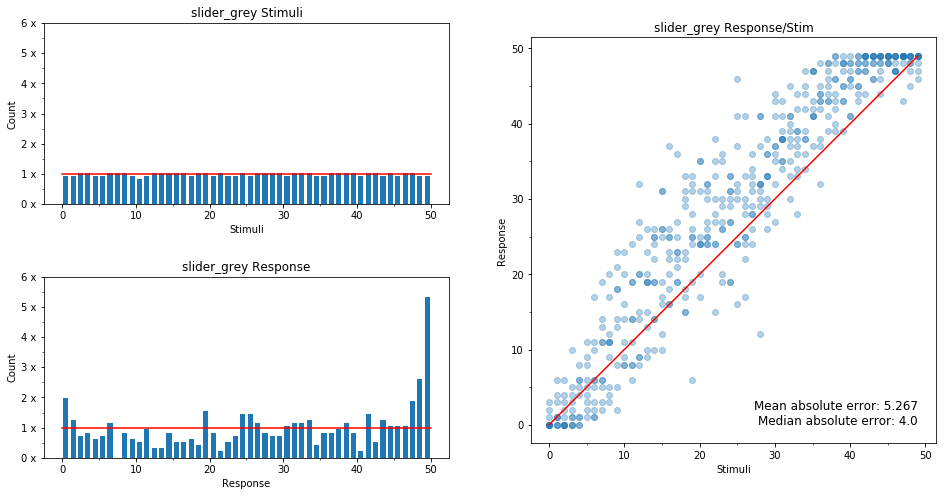

slider_num


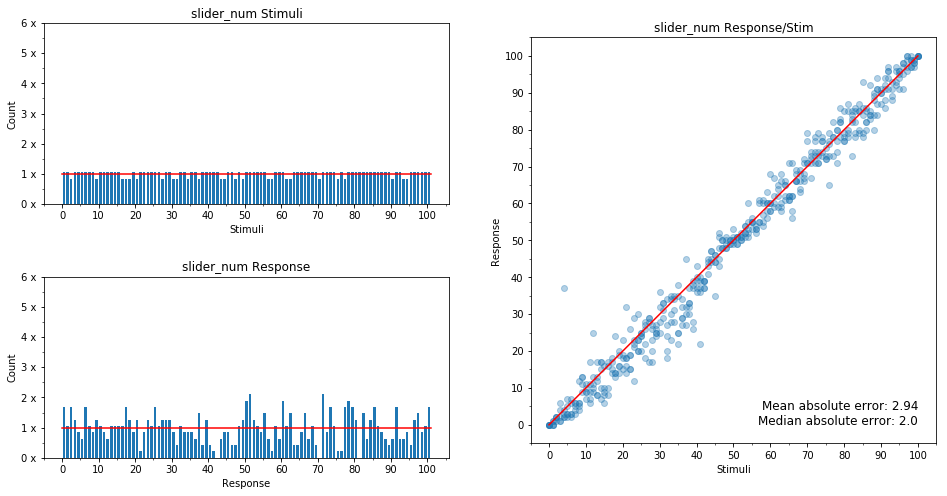

wrist_grey


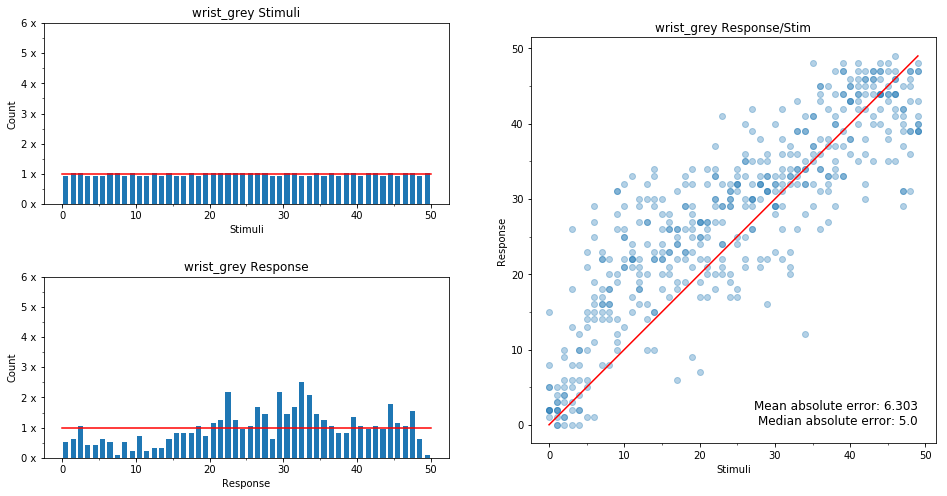

wrist_num


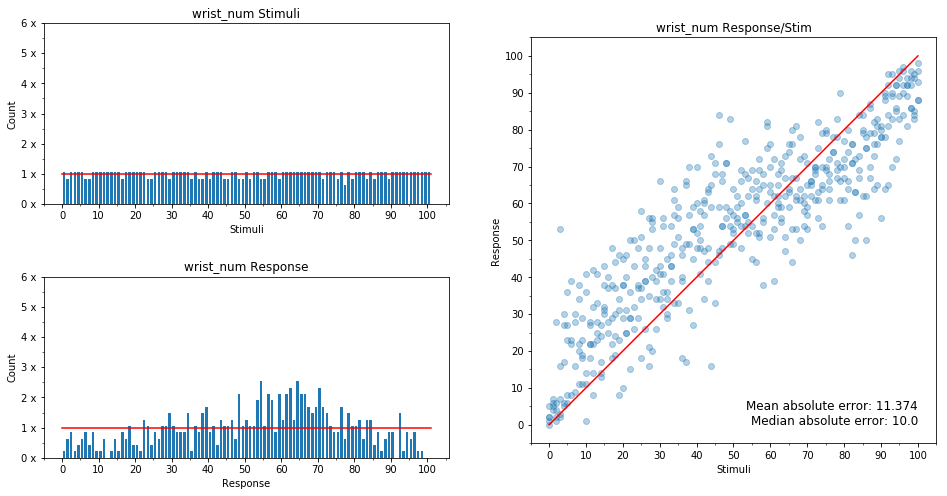

arm_grey


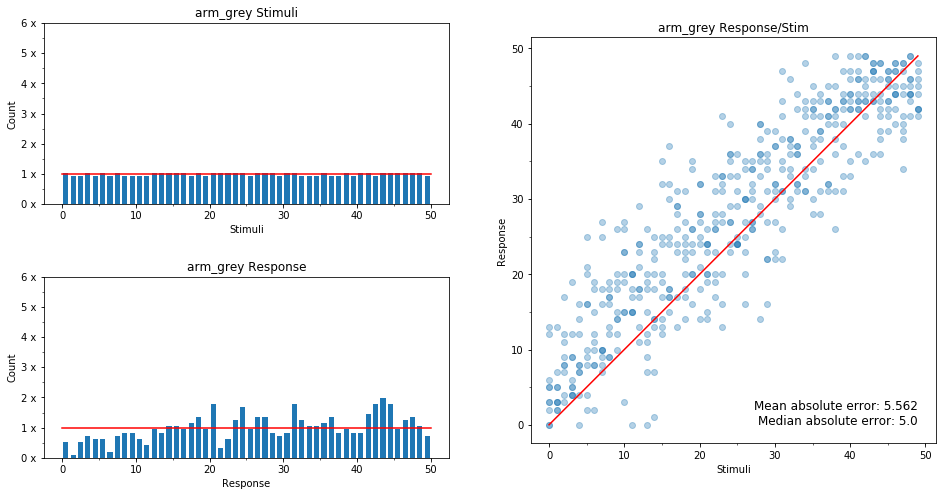

arm_num


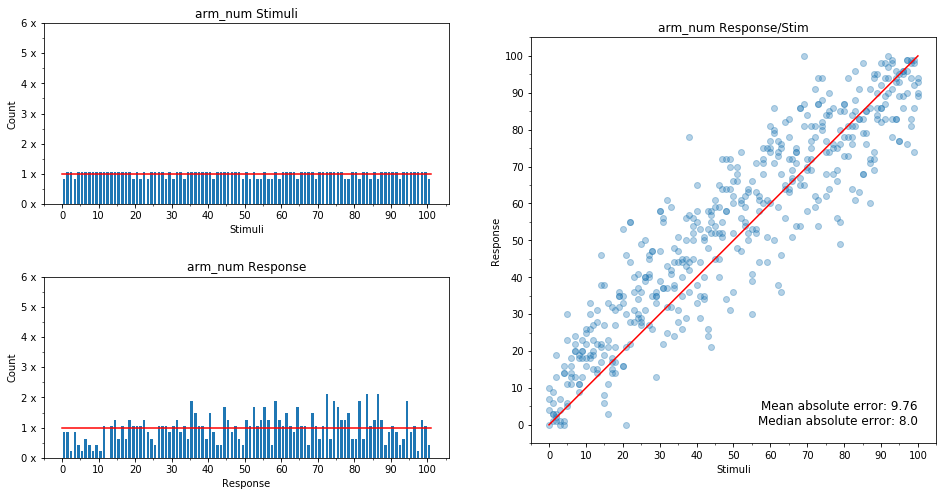

In [25]:
errors = []
for i in range(6):
    print(types[i])
    x = type_frames[i].loc[: , columns[7]]
    y = round(type_frames[i].loc[: , columns[8]])
    if "grey" in types[i]:
        hist1, bins1 = np.histogram(x, bins=range(51))
        hist2, bins2 = np.histogram(y, bins=range(51))
        yMax = 49
    else:
        hist1, bins1 = np.histogram(x, bins=range(102))
        hist2, bins2 = np.histogram(y, bins=range(102))
        yMax = 100
        
    width1 = 0.7 * (bins1[1] - bins1[0])
    center1 = (bins1[:-1] + bins1[1:]) / 2
    width2 = 0.7 * (bins2[1] - bins2[0])
    center2 = (bins2[:-1] + bins2[1:]) / 2
    y_limit = 6
    hist_mean = np.mean(hist2)
    
    # Create figure with grid
    fig = plt.figure(figsize=(16,8), facecolor='white')
    gs = gridspec.GridSpec(2,2)
    # General tick marks
    majorLocator = MultipleLocator(10)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(5)

    # Add 1st plot (hist)    
    ax1 = fig.add_subplot(gs[0,0])
    ax1.bar(center1, hist1/hist_mean, align='center', width=width1)
    ax1.set_title(types[i]+" Stimuli")
    ax1.set_xlabel("Stimuli")
    ax1.set_ylabel("Count")
    ax1.set_ylim(0,y_limit)
    ax1.xaxis.set_major_locator(majorLocator)
    ax1.xaxis.set_minor_locator(minorLocator)
    ax1.plot([0,yMax+1],[1,1],color='red')
    ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax1.set_yticklabels(["0 x"] + [str(i)+" x" for i in range(1,y_limit+1)])
    #ax1.plot(range(yMax+1),hist1,color='red')
    
    # Add 2st plot (hist)
    ax2 = fig.add_subplot(gs[1,0])
    ax2.set_title(types[i]+" Response")
    ax2.bar(center2, hist2/hist_mean, align='center', width=width2)
    ax2.set_xlabel("Response")
    ax2.set_ylabel("Count")
    ax2.set_ylim(0,y_limit)
    ax2.xaxis.set_major_locator(majorLocator)
    ax2.xaxis.set_minor_locator(minorLocator)
    ax2.plot([0,yMax+1],[1,1],color='red')
    ax2.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.set_yticklabels(["0 x"] + [str(i)+" x" for i in range(1,y_limit+1)])
    #ax2.plot(range(yMax+1),hist1,color='red')
    
    # Add 3rd plot (scatter)
    ax3 = fig.add_subplot(gs[0:,1],aspect=1)
    ax3.set_title(types[i]+" Response/Stim")
    corrThres = yMax/20
    # Green upper
    #ax3.fill([0,0,yMax-corrThres,yMax],[0,corrThres,yMax,yMax], color = 'green', alpha=0.2)
    # Green Lower
    #ax3.fill([0,corrThres,yMax,yMax],[0,0,yMax-corrThres,yMax], color = 'green', alpha=0.2)
    # Orange upper
    #ax3.fill([0,0,yMax-2*corrThres,yMax-corrThres],[corrThres,2*corrThres,yMax,yMax], color = 'orange', alpha=0.2)
    # Orange lower
    #ax3.fill([corrThres,2*corrThres,yMax,yMax],[0,0,yMax-2*corrThres,yMax-corrThres], color = 'orange', alpha=0.2)
    ax3.scatter(x,y,alpha=1.0/3)
    ax3.plot([0,yMax],[0,yMax],color='red')
    ax3.set_xlabel("Stimuli")
    ax3.set_ylabel("Response")
    mean_error = mean_absolute_error(x,y)
    median_error = median_absolute_error(x,y)
    errors.append((mean_error,median_error))
    txt1 = "Mean absolute error: "+str(round(mean_error,3))
    txt2 = "Median absolute error: "+str((median_error))
    ax3.text(yMax, 0.01, txt1+"\n"+txt2, horizontalalignment='right', fontsize=12)
    ax3.xaxis.set_major_locator(majorLocator)
    ax3.xaxis.set_minor_locator(minorLocator)
    ax3.yaxis.set_major_locator(majorLocator)
    ax3.yaxis.set_minor_locator(minorLocator)

    # Spacing
    gs.update(wspace=0.2, hspace=0.4)
    plt.savefig("plots/"+types[i]+"_plots.png")
    plt.show()
    #break

In [26]:
errors_df = pd.DataFrame()
for i in range(6):
    tmp_df = pd.DataFrame([[types[i], errors[i][0], errors[i][1]]], columns=["type", "mean absolute error", "median absolute error"])
    errors_df = errors_df.append(tmp_df)
print("MEAN ABOSLUTE ERROR")
print("Mean of mean abosulte error:",np.mean(errors_df.loc[: , 'mean absolute error']))
print("Median of mean abosulte error:",np.median(errors_df.loc[: , 'mean absolute error']))
print('MEDIAN ABOSLUTE ERROR')
print("Mean of median abosulte error:",np.mean(errors_df.loc[: , 'median absolute error']))
print("Median of median abosulte error:",np.median(errors_df.loc[: , 'median absolute error']))
errors_df

MEAN ABOSLUTE ERROR
Mean of mean abosulte error: 6.867819059494589
Median of mean abosulte error: 5.932606993736952
MEDIAN ABOSLUTE ERROR
Mean of median abosulte error: 5.666666666666667
Median of median abosulte error: 5.0


,type,mean absolute error,median absolute error
0,slider_grey,5.267223,4.0
0,slider_num,2.939583,2.0
0,wrist_grey,6.302714,5.0
0,wrist_num,11.374477,10.0
0,arm_grey,5.562500,5.0
0,arm_num,9.760417,8.0


<h1>Plots on 0-10 scale #cancelled</h1> (boxes)

slider_grey slider_num


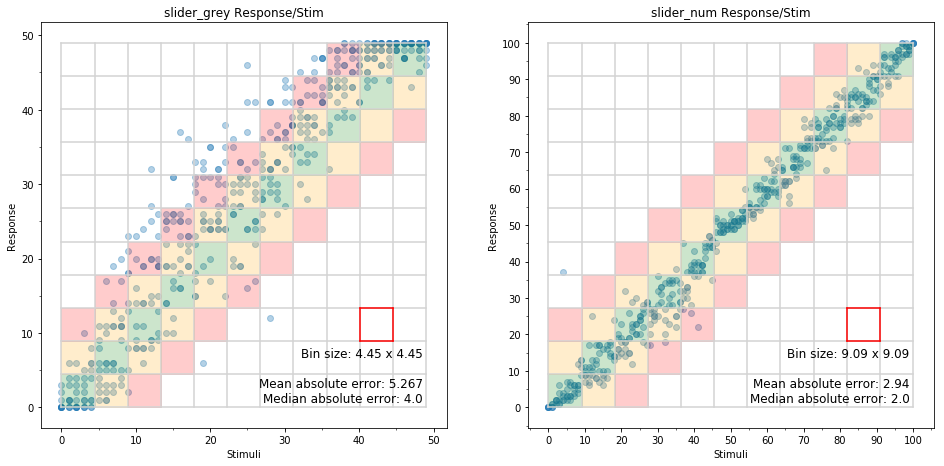

wrist_grey wrist_num


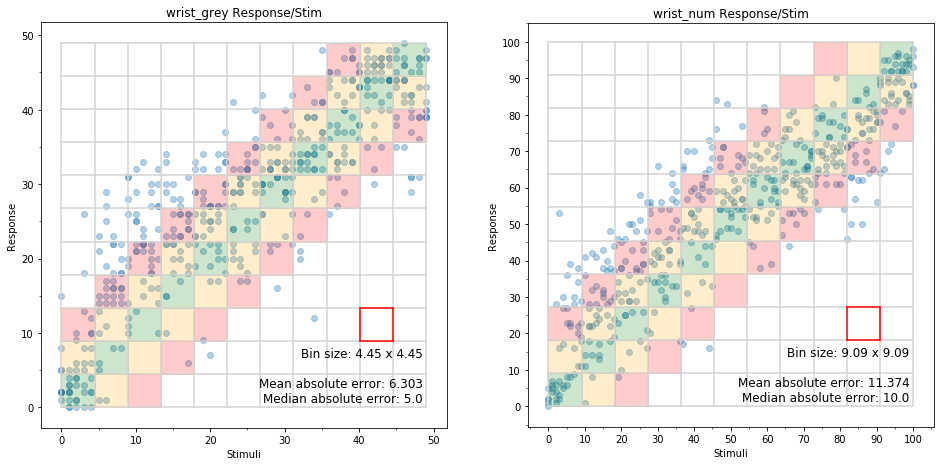

arm_grey arm_num


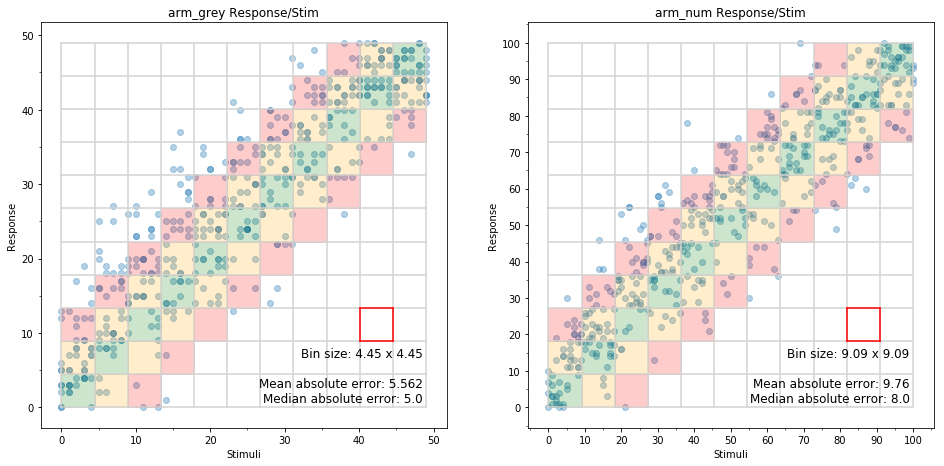

In [27]:
errors = []
for iM in range(0,6,2):
    # Create figure with grid
    fig = plt.figure(figsize=(16,8), facecolor='white')
    gs = gridspec.GridSpec(1,2)
    # General tick marks
    majorLocator = MultipleLocator(10)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(5)
    print(types[iM],types[iM+1])
    for im in range(2):
        i = iM+im
        x = type_frames[i].loc[: , columns[7]]
        y = round(type_frames[i].loc[: , columns[8]])
        if "grey" in types[i]:
            yMax = 49
        else:
            yMax = 100
        # Add 3rd plot (scatter)
        ax3 = fig.add_subplot(gs[0,im],aspect=1)
        ax3.set_title(types[i]+" Response/Stim")
        bins = 11
        divider = yMax/bins
        for b in range(bins):
            ax3.plot([divider*b,divider*b],[0,yMax],color='lightgrey')
            ax3.plot([0,yMax],[divider*b,divider*b],color='lightgrey')
            ax3.fill([b*divider,b*divider,(b+1)*divider,(b+1)*divider],
                     [b*divider,(b+1)*divider,(b+1)*divider,b*divider], color = 'green', alpha=0.2)
        b += 1
        ax3.plot([divider*b,divider*b],[0,yMax],color='lightgrey')
        ax3.plot([0,yMax],[divider*b,divider*b],color='lightgrey')
        for b in range(bins-1):
            # Upper boxes
            ax3.fill([b*divider,b*divider,(b+1)*divider,(b+1)*divider],
                     [(b+1)*divider,(b+2)*divider,(b+2)*divider,(b+1)*divider], color = 'orange', alpha=0.2)
            # Lower boxes
            ax3.fill([(b+1)*divider,(b+1)*divider,(b+2)*divider,(b+2)*divider],
                     [b*divider,(b+1)*divider,(b+1)*divider,b*divider], color = 'orange', alpha=0.2)
        for b in range(bins-2):
            # Upper boxes
            ax3.fill([b*divider,b*divider,(b+1)*divider,(b+1)*divider],
                     [(b+2)*divider,(b+3)*divider,(b+3)*divider,(b+2)*divider], color = 'red', alpha=0.2)
            # Lower boxes
            ax3.fill([(b+2)*divider,(b+2)*divider,(b+3)*divider,(b+3)*divider],
                     [b*divider,(b+1)*divider,(b+1)*divider,b*divider], color = 'red', alpha=0.2)
        # Green upper
        #ax3.fill([0,0,yMax-corrThres,yMax],[0,corrThres,yMax,yMax], color = 'green', alpha=0.2)
        # Green Lower
        #ax3.fill([0,corrThres,yMax,yMax],[0,0,yMax-corrThres,yMax], color = 'green', alpha=0.2)
        # Orange upper
        #ax3.fill([0,0,yMax-2*corrThres,yMax-corrThres],[corrThres,2*corrThres,yMax,yMax], color = 'orange', alpha=0.2)
        # Orange lower
        #ax3.fill([corrThres,2*corrThres,yMax,yMax],[0,0,yMax-2*corrThres,yMax-corrThres], color = 'orange', alpha=0.2)
        ax3.scatter(x,y,alpha=1.0/3)
        #ax3.plot([0,yMax],[0,yMax],color='green')
        # Red box
        ax3.plot([yMax-(2*divider),yMax-(1*divider)],[divider*2,divider*2],color='red')
        ax3.plot([yMax-(2*divider),yMax-(1*divider)],[divider*3,divider*3],color='red')
        ax3.plot([yMax-(2*divider),yMax-(2*divider)],[divider*2,divider*3],color='red')
        ax3.plot([yMax-(1*divider),yMax-(1*divider)],[divider*2,divider*3],color='red')
        ax3.set_xlabel("Stimuli")
        ax3.set_ylabel("Response")
        mean_error = mean_absolute_error(x,y)
        median_error = median_absolute_error(x,y)
        errors.append((mean_error,median_error))
        txt0 = "Bin size: "+str(round(divider,2))+" x "+str(round(divider,2))
        txt1 = "Mean absolute error: "+str(round(mean_error,3))
        txt2 = "Median absolute error: "+str((median_error))
        ax3.text(yMax-divider/10, divider/6, txt0+"\n\n"+txt1+"\n"+txt2, horizontalalignment='right', fontsize=12)
        ax3.xaxis.set_major_locator(majorLocator)
        ax3.xaxis.set_minor_locator(minorLocator)
        ax3.yaxis.set_major_locator(majorLocator)
        ax3.yaxis.set_minor_locator(minorLocator)

        # Spacing
        #gs.update(wspace=0.2, hspace=0.4)
        
    plt.show()
    #break

<h1>Plots on 0-10 scale</h1> (lines)

slider_grey slider_num
4.45
9.09


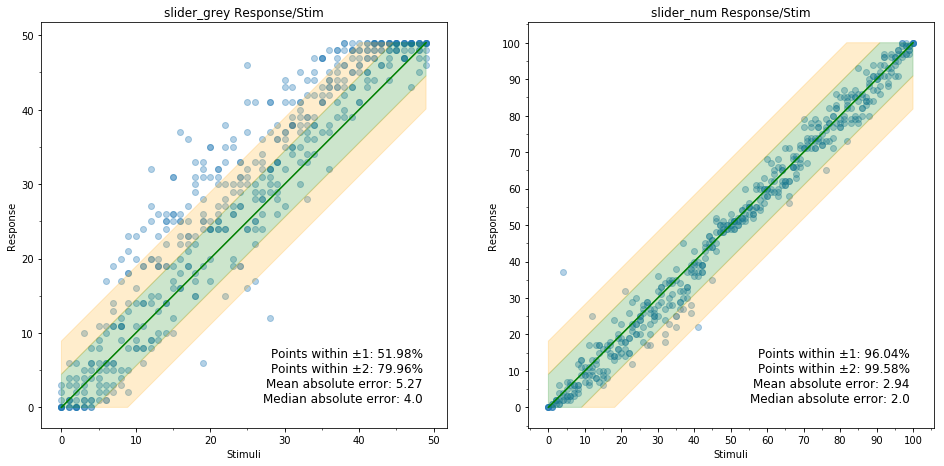

wrist_grey wrist_num


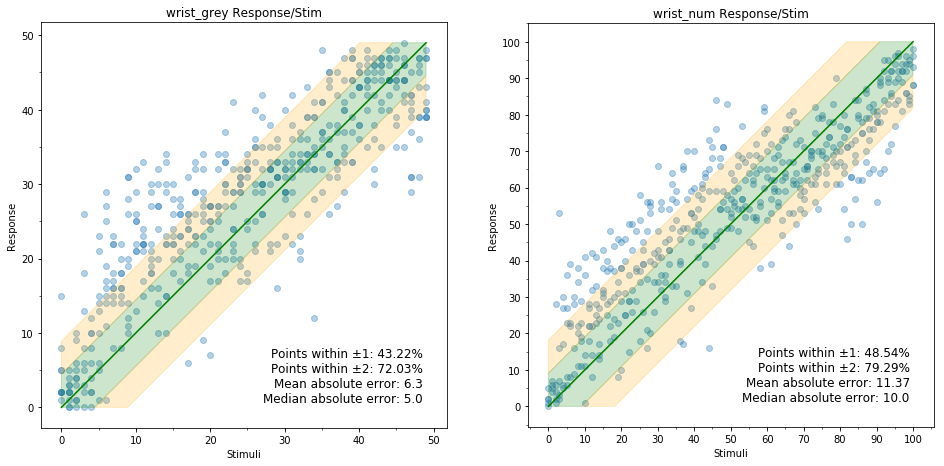

arm_grey arm_num


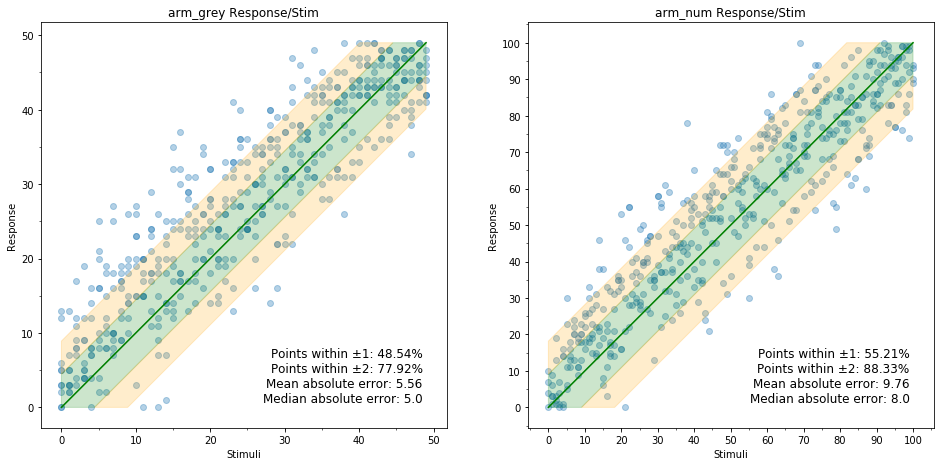

In [28]:
errors = []
for iM in range(0,6,2):
    # Create figure with grid
    fig = plt.figure(figsize=(16,8), facecolor='white')
    gs = gridspec.GridSpec(1,2)
    # General tick marks
    majorLocator = MultipleLocator(10)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(5)
    print(types[iM],types[iM+1])
    for im in range(2):
        i = iM+im
        x = type_frames[i].loc[: , columns[7]]
        y = round(type_frames[i].loc[: , columns[8]])
        if "grey" in types[i]:
            yMax = 49
        else:
            yMax = 100
        # Add 3rd plot (scatter)
        ax3 = fig.add_subplot(gs[0,im],aspect=1)
        ax3.set_title(types[i]+" Response/Stim")
        bins = 11
        divider = yMax/bins
        corrThres = divider/1
        
        ae = x.subtract(y).abs()
        pm1 = 0
        pm2 = 0
        pm3 = 0
        for e in ae:
            if e <= divider:
                pm1 += 1
                pm2 += 1
                pm3 += 1
            elif e <= divider*2:
                pm2 += 1
                pm3 +=1
        # Green upper
        ax3.fill([0,0,yMax-corrThres,yMax],[0,corrThres,yMax,yMax], color = 'green', alpha=0.2)
        # Green Lower
        ax3.fill([0,corrThres,yMax,yMax],
                 [0,0,yMax-corrThres,yMax], color = 'green', alpha=0.2)
        # Orange upper
        ax3.fill([0,0,yMax-2*corrThres,yMax-corrThres],
                 [corrThres,2*corrThres,yMax,yMax], color = 'orange', alpha=0.2)
        # Orange lower
        ax3.fill([corrThres,2*corrThres,yMax,yMax],
                 [0,0,yMax-2*corrThres,yMax-corrThres], color = 'orange', alpha=0.2)
        # Red upper
        #ax3.fill([0,0,yMax-3*corrThres,yMax-2*corrThres],
        #         [2*corrThres,3*corrThres,yMax,yMax], color = 'red', alpha=0.2)
        # Red lower
        #ax3.fill([2*corrThres,3*corrThres,yMax,yMax],
        #         [0,0,yMax-3*corrThres,yMax-2*corrThres], color = 'red', alpha=0.2)
        ax3.scatter(x,y,alpha=1.0/3)
        ax3.plot([0,yMax],[0,yMax],color='green')
        # Red box
        ax3.set_xlabel("Stimuli")
        ax3.set_ylabel("Response")
        mean_error = mean_absolute_error(x,y)
        median_error = median_absolute_error(x,y)
        errors.append((mean_error,median_error))
        txt1 = "Mean absolute error: "+str(round(mean_error,2))
        txt2 = "Median absolute error: "+str((median_error))
        txt3 = "Points within ±1: "+str(round(pm1/len(ae)*100,2))+"%\n"
        txt3 += "Points within ±2: "+str(round(pm2/len(ae)*100,2))+"%"
        ax3.text(yMax-divider/10, divider/6, txt3+"\n"+txt1+"\n"+txt2, horizontalalignment='right', fontsize=12)
        ax3.xaxis.set_major_locator(majorLocator)
        ax3.xaxis.set_minor_locator(minorLocator)
        ax3.yaxis.set_major_locator(majorLocator)
        ax3.yaxis.set_minor_locator(minorLocator)
        if i in [0,1]:
            print(round(divider,2))
        
    plt.show()
    #break

<h1>Box blots</h1>

In [29]:
errors = []
for iM in range(0,6,2):
    # Create figure with grid
    fig = plt.figure(figsize=(16,8), facecolor='white')
    gs = gridspec.GridSpec(1,2)
    # General tick marks
    majorLocator = MultipleLocator(10)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(5)
    print(types[iM],types[iM+1])
    for im in range(2):
        i = iM+im
        x = type_frames[i].loc[: , columns[7]]
        y = round(type_frames[i].loc[: , columns[8]])
        if "grey" in types[i]:
            yMax = 49
        else:
            yMax = 100
        df['value_group'] = pd.cut(x, bins=range(0, 101, 20))
        break
        ax = sns.boxplot(x="value_group", y="combined_delta", data=df)
        break
    
    break

slider_grey slider_num


<Figure size 1600x800 with 0 Axes>

In [30]:
print(type(x))

<class 'pandas.core.series.Series'>


<h1>ScatterPlots with individual participants</h1>

In [31]:
list1 = [3,2,4,1, 1]
list2 = ['three', 'two', 'four', 'one', 'one2']
list1, list2 = zip(*sorted(zip(list1, list2)))
print(list1)
print(list2)

(1, 1, 2, 3, 4)
('one', 'one2', 'two', 'three', 'four')


slider_grey


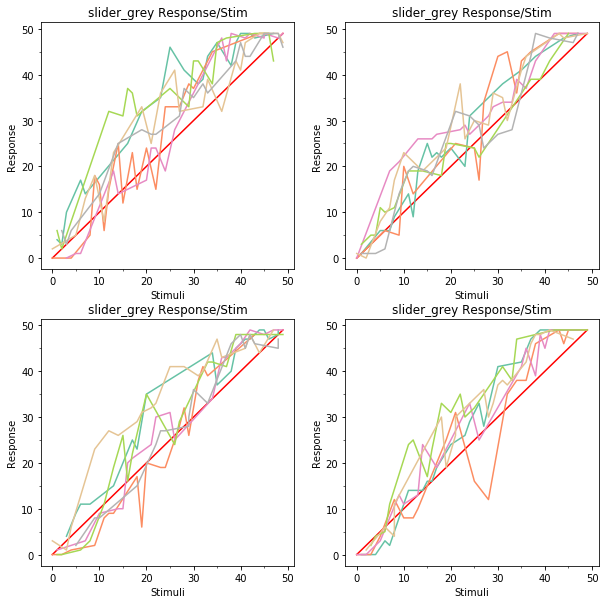

slider_num


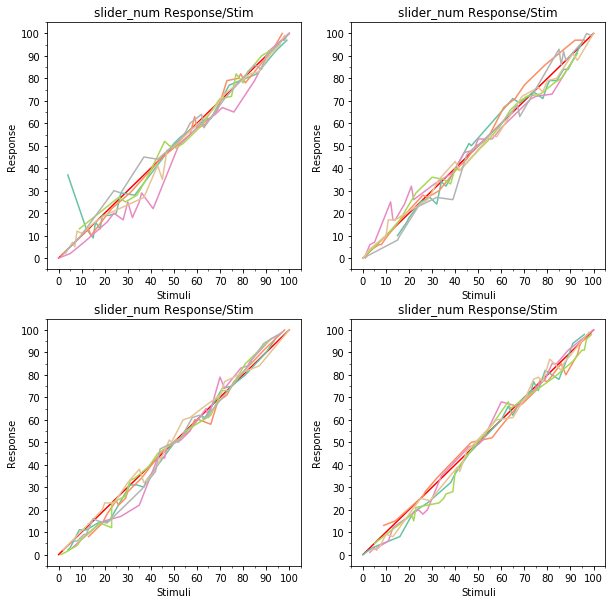

wrist_grey


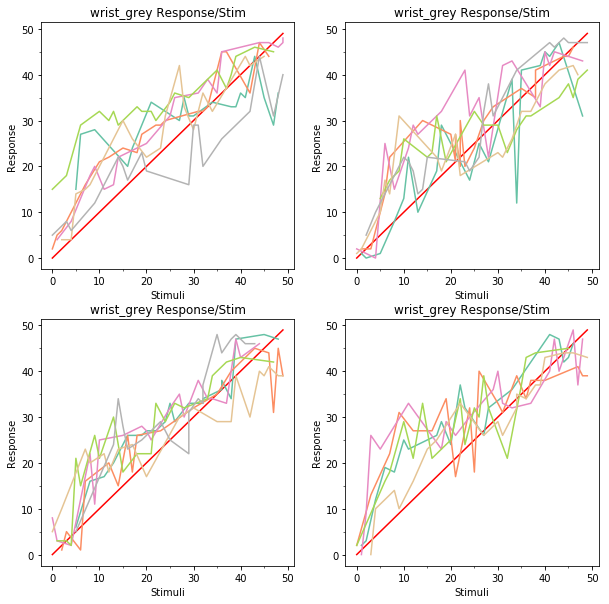

wrist_num


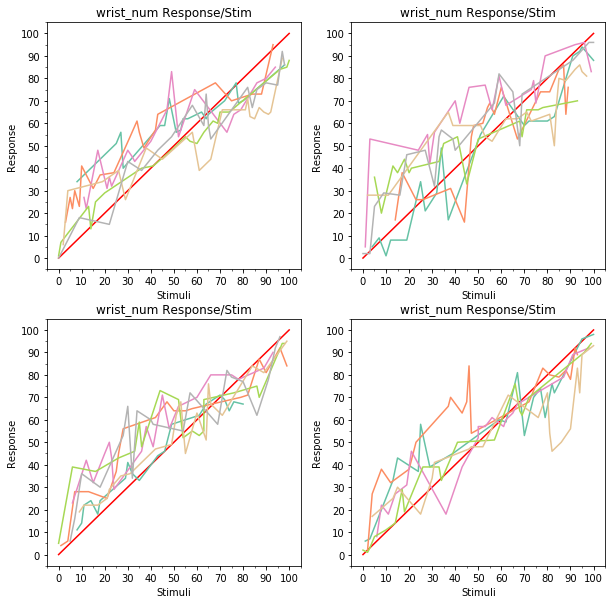

arm_grey


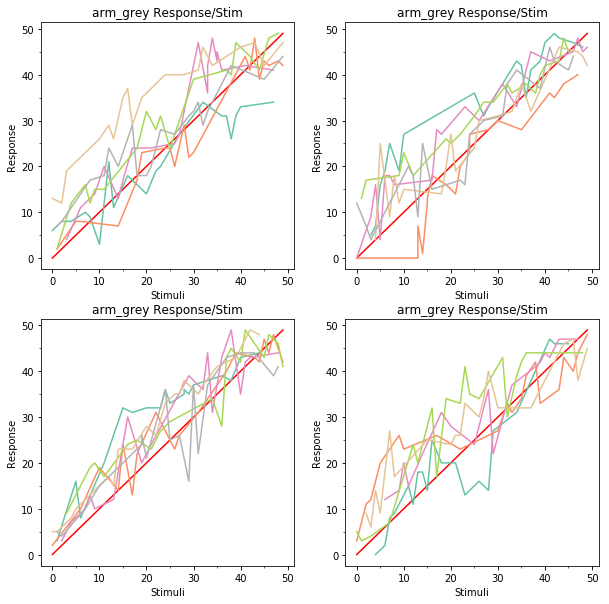

arm_num


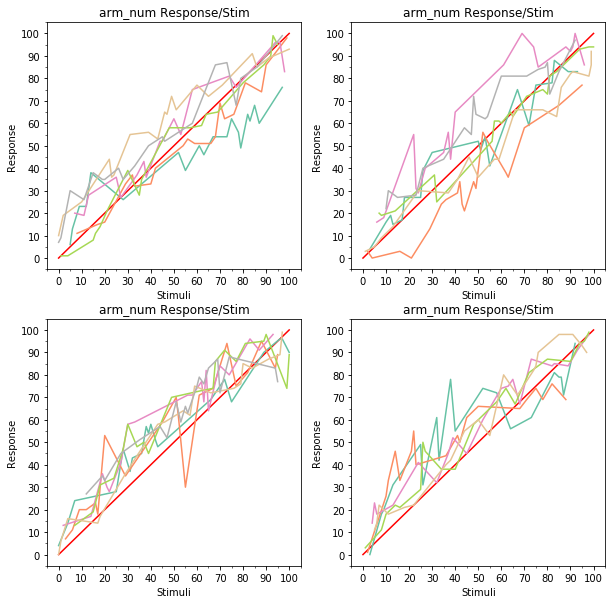

In [32]:
errors = []
for i in range(6):
    print(types[i])
    if "grey" in types[i]:
        yMax = 49
    else:
        yMax = 100
        
    # Create figure with grid
    fig = plt.figure(figsize=(10,10), facecolor='white')
    gs = gridspec.GridSpec(2,2)
    fig_placement = [(0,1),(1,0),(1,1)]

    # General tick marks
    majorLocator = MultipleLocator(10)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(5)

 
    # Add 3rd plot (scatter)
    # Add 1st plot 
    ax3 = fig.add_subplot(gs[0,0])
    ax3.set_title(types[i]+" Response/Stim")
    ax3.plot([0,yMax],[0,yMax],color='red')
    ax3.set_xlabel("Stimuli")
    ax3.set_ylabel("Response")
    ax3.xaxis.set_major_locator(majorLocator)
    ax3.xaxis.set_minor_locator(minorLocator)
    ax3.yaxis.set_major_locator(majorLocator)
    ax3.yaxis.set_minor_locator(minorLocator)
       
    lines_per_graph = 6
    plot_all = 0
    if not plot_all:
        colors = cm.Set2(np.linspace(0, 1, lines_per_graph))
        mod_val = lines_per_graph
    else:
        colors = cm.Dark2(np.linspace(0, 1, max(df['id'])))
        mod_val = 999

    for p in range(max(df['id'])):
            tmp_df = type_frames[i].loc[type_frames[i]['id']==p]
            x = tmp_df.loc[: , columns[7]]+(0*p)
            y = round(tmp_df.loc[: , columns[8]])+(0*p)
            x, y = zip(*sorted(zip(x, y)))
            ax3.plot(x,y,alpha=1,color=colors[p%mod_val])
            if p%lines_per_graph == lines_per_graph-1 and not plot_all:
                #plt.show()
                ax3 = fig.add_subplot(gs[fig_placement.pop(0)])
                ax3.set_title(types[i]+" Response/Stim")
                ax3.plot([0,yMax],[0,yMax],color='red')
                ax3.set_xlabel("Stimuli")
                ax3.set_ylabel("Response")
                ax3.xaxis.set_major_locator(majorLocator)
                ax3.xaxis.set_minor_locator(minorLocator)
                ax3.yaxis.set_major_locator(majorLocator)
                ax3.yaxis.set_minor_locator(minorLocator)
                

    plt.show()

<h1>Response times</h1>

In [33]:
participants_frames = []
participants_time_mean = pd.DataFrame()
participants_time_median = pd.DataFrame()
participants_time_std = pd.DataFrame()
participants_time_var = pd.DataFrame()

for i in range(max(df.loc[: , "id"])+1):
    participants_frames.append(df.loc[df['id'] == i])
    
for pf in participants_frames:
    p_id = pf['id'].iloc[0]
    p_time_std = []
    p_time_var = []
    p_time_mean = []
    p_time_median = []
    for ty in types:
        tmp_df = pf.loc[pf['type'] == ty]
        t = tmp_df.loc[: , 'reaction_time']
        p_time_std.append(np.std(t))
        p_time_var.append(np.var(t))
        p_time_mean.append(np.mean(t))
        p_time_median.append(np.median(t))
        
    mean_time_std = np.mean(p_time_std)
    median_time_std = np.median(p_time_std)
    mean_time_var = np.mean(p_time_var)
    median_time_var = np.median(p_time_var)
    mean_time_mean = np.mean(p_time_mean)
    median_time_mean = np.median(p_time_mean)
    mean_time_median = np.mean(p_time_median)
    median_time_median = np.median(p_time_median)
    
    tmp_df_time_std = pd.DataFrame([[p_id]+p_time_std+[mean_time_std,median_time_std]], columns=["id"]+types+["mean STD",'median STD'])
    participants_time_std = participants_time_std.append(tmp_df_time_std)
    tmp_df_time_var = pd.DataFrame([[p_id]+p_time_var+[mean_time_var,median_time_var]], columns=["id"]+types+["mean VAR",'median VAR'])
    participants_time_var = participants_time_var.append(tmp_df_time_var)
    tmp_df_time_mean = pd.DataFrame([[p_id]+p_time_mean+[mean_time_mean,median_time_mean]], columns=["id"]+types+["mean MEAN",'median MEAN'])
    participants_time_mean = participants_time_mean.append(tmp_df_time_mean)
    tmp_df_time_median = pd.DataFrame([[p_id]+p_time_median+[mean_time_median,median_time_median]], columns=["id"]+types+["mean MEDIAN",'median MEDIAN'])
    participants_time_median = participants_time_median.append(tmp_df_time_median)
    
#    break

In [34]:
np.median([4920.90,4977.90,4779.60,4673.35,4718.35,6245.35])

4850.25

In [35]:
print("- - - Mean - - -")
for t in types:
    print(t)
    print(np.mean(participants_time_mean[t])/1000.0)
    print()

print("- - - Median - - -")
for t in types:
    print(t)
    print(np.mean(participants_time_median[t])/1000.0)
    print()

    
print('- - - Var - - -')
for t in types:
    print(t)
    print(np.mean(participants_time_var[t])/1000.0)
    print()
    
print('- - - Std - - -')
for t in types:
    print(t)
    print(np.mean(participants_time_std[t])/1000.0)
    print()

- - - Mean - - -
slider_grey
3.5889981359649124

slider_num
4.551975

wrist_grey
4.088885307017544

wrist_num
4.376159100877193

arm_grey
4.3378854166666665

arm_num
4.617912500000001

- - - Median - - -
slider_grey
2.6715625

slider_num
3.9418958333333336

wrist_grey
3.1948333333333334

wrist_num
3.6140416666666666

arm_grey
3.5626875

arm_num
3.8232708333333334

- - - Var - - -
slider_grey
18489.88894759205

slider_num
8263.561595

wrist_grey
12458.4766062223

wrist_num
10847.820334290453

arm_grey
15365.447956770835

arm_num
11073.200107291668

- - - Std - - -
slider_grey
2.980654697359372

slider_num
2.4358592163127946

wrist_grey
2.5877825131310987

wrist_num
2.552970935965525

arm_grey
2.522191362053747

arm_num
2.63269748067996



<h1>Pilot test times</h1>

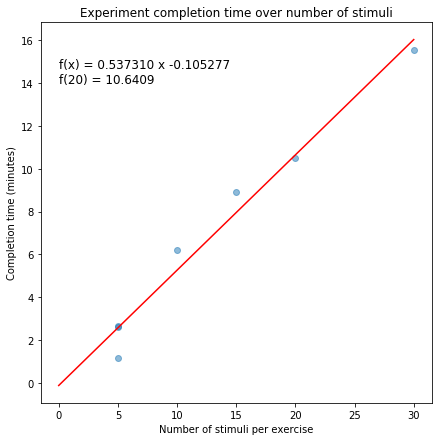

In [36]:
nStim = [5,10,5,5,20,30,15]
tMin = [1.160183333,6.229216667,2.662333333,2.621933333,10.51216667,15.51116667,8.923983333]
plt.figure(figsize=(7,7))
plt.scatter(nStim,tMin,alpha=0.5)
# calc the trendline
z = np.polyfit(nStim, tMin, 1)
p = np.poly1d(z)
plt.plot([0,30],[p(0),p(30)],"r")
plt.text(0, 14, "f(x) = %.6f x %.6f"%(z[0],z[1])+"\nf(20) = "+str(round(p(20),4)), horizontalalignment='left', fontsize=12)
plt.title('Experiment completion time over number of stimuli')
plt.xlabel('Number of stimuli per exercise')
plt.ylabel('Completion time (minutes)')
plt.show()

In [37]:
print(p(15))
print(p(20))
print(p(25))

7.954376755539472
10.640928072131578
13.327479388723683
